### Imports


In [1]:
import transformers, datasets
import numpy as np
from datasets import load_dataset
transformers.__version__, datasets.__version__

('4.39.3', '2.18.0')

### WandB for logging performance metrics


In [2]:
import os 
os.environ['WANDB_API_KEY'] = '##################################'

### Dataset

In [4]:
import pandas as pd
df = pd.read_csv("/kaggle/working/AirlineTweets.csv")

In [5]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['label'] = df['airline_sentiment'].map(target_map)
df.rename(columns={'text': 'sentence'}, inplace=True)

In [6]:
from datasets import Dataset

raw_datasets = Dataset.from_pandas(df[["sentence", "label"]])

In [7]:
raw_datasets

Dataset({
    features: ['sentence', 'label'],
    num_rows: 14640
})

In [8]:
raw_datasets = raw_datasets.train_test_split(test_size=0.3, seed=42)

In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [10]:
raw_datasets['train'].features

{'sentence': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

### Model and Tokenizer

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig # Autoconfig 

# checkpoint = "bert-base-uncased"
checkpoint = "distilbert-base-uncased"

config = AutoConfig.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.39.3",
  "vocab_size": 30522
}

In [13]:
config.id2label, config.label2id

({0: 'LABEL_0', 1: 'LABEL_1'}, {'LABEL_0': 0, 'LABEL_1': 1})

In [14]:
config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [15]:
config.id2label, config.label2id

({1: 'positive', 0: 'negative', 2: 'neutral'},
 {'positive': 1, 'negative': 0, 'neutral': 2})

In [16]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config = config)  # no need of num_labels now

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
!pip install torchinfo
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

In [18]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

tokenized_datasets

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4392
    })
})

### Training Arguments

In [19]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'training_dir',
    num_train_epochs = 5,
    learning_rate = 1e-5,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 128,
    evaluation_strategy='steps',
    save_strategy='steps',
    logging_steps = 0.05,
    logging_dir="./logs",
    save_steps = 0.05,
    load_best_model_at_end = True,
    run_name= "airplane_tweet_run1",
    fp16 = False,
    save_total_limit = 3, 
    report_to="wandb")

### Trainer and performance metrics 

In [20]:
from transformers import Trainer
import torch
lang = 'eng'
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss, f1_score, confusion_matrix
from torch.nn import CrossEntropyLoss
def compute_metrics(pred):
    global num_labels
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    logits = torch.tensor(pred.predictions)
    labels = torch.tensor(labels)
    return {
        'accuracy@'+lang: acc,
        'f1@'+lang: f1,
        'precision@'+lang: precision,
        'recall@'+lang: recall,
     }



2024-05-29 08:20:48.410720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 08:20:48.410862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 08:20:48.538742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Training

In [22]:
trainer.train()

wandb: Currently logged in as: gautam-taaresh. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy@eng,F1@eng,Precision@eng,Recall@eng
41,0.923400,0.783765,0.640027,0.260169,0.213342,0.333333
82,0.758600,0.653900,0.697404,0.452237,0.804423,0.460169
123,0.617900,0.558977,0.805328,0.727294,0.742610,0.723865
164,0.543200,0.494493,0.819444,0.750808,0.771957,0.735901
205,0.474400,0.466948,0.818761,0.752435,0.764237,0.743789
246,0.454800,0.456775,0.826047,0.758548,0.776693,0.748330
287,0.455300,0.448929,0.826047,0.766673,0.765939,0.771376
328,0.419100,0.447530,0.829235,0.761944,0.778098,0.758586
369,0.398500,0.443496,0.826958,0.772433,0.767261,0.778995
410,0.401100,0.443615,0.829235,0.775208,0.782018,0.769582


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=805, training_loss=0.4506566195754531, metrics={'train_runtime': 250.8736, 'train_samples_per_second': 204.246, 'train_steps_per_second': 3.209, 'total_flos': 668827404370080.0, 'train_loss': 0.4506566195754531, 'epoch': 5.0})

### Inference

In [23]:
!ls "/kaggle/working/training_dir/"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


checkpoint-697	checkpoint-738	checkpoint-779


In [24]:
from transformers import pipeline

savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-779',
                      device='cuda')
config = AutoConfig.from_pretrained("training_dir/checkpoint-779")

In [25]:
test_pred = savedmodel(raw_datasets['test']['sentence'])
test_pred[0], config.label2id

({'label': 'positive', 'score': 0.9293567538261414},
 {'negative': 0, 'neutral': 2, 'positive': 1})

In [26]:
test_pred = [config.label2id.get(d["label"]) for d in test_pred]  

In [27]:
print("acc:", accuracy_score(raw_datasets['test']['label'], test_pred))
print("f1:", f1_score(raw_datasets['test']['label'], test_pred, average='macro'))

acc: 0.8378870673952641
f1: 0.7833203779280441


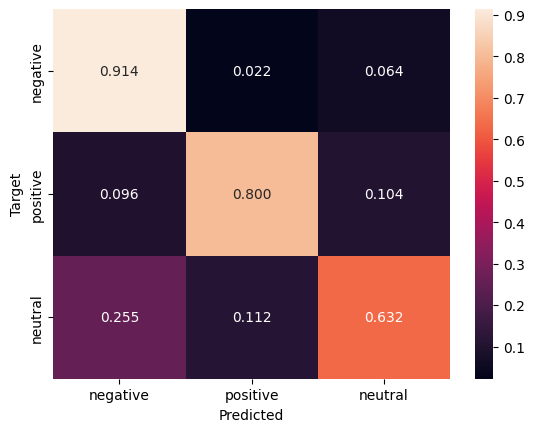

In [28]:
import seaborn as sns 
import matplotlib.pyplot as plt

cm = confusion_matrix(tokenized_datasets['test']['label'], test_pred, normalize='true')

ax= sns.heatmap(cm, annot= True, fmt = ".3f", xticklabels = ["negative", "positive","neutral"],
           yticklabels = ["negative", "positive","neutral"], )

ax.set(xlabel="Predicted", ylabel="Target")
plt.show()